#### Se importan las librerias

In [48]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, plot_roc_curve

#### Se importa el dataset de fraudes con las siguientes columnas

* Step: representa una unidad de tiempo donde 1 step equivale a 1 hora
* type: tipo de transacción en línea
* amount: el importe de la transacción
* nameOrig: cliente que inicia la transacción
* oldbalanceOrg: saldo antes de la transacción
* newbalanceOrig: saldo después de la transacción
* nameDest: destinatario de la transacción
* oldbalanceDest: saldo inicial del destinatario antes de la transacción
* newbalanceDest: el nuevo saldo del destinatario después de la transacción
* isFraud: transacción fraudulenta

In [2]:
DATASET_PATH = r"C:\Users\54922\GITHUB\TP_entrega_AM1\Tp1\fraude.csv"
dataset = pd.read_csv(DATASET_PATH)
dataset_=dataset.copy().drop(columns={"isFlaggedFraud"}) #se copia el dataset y se dropea la columna isFlaggedFraud, ya que no se utilizrá


##### Se han considerado tres opciones de balanceo: 

> * Balanceo de "isFraud" mediante subsampling, sin tomar tipo de transferencia y utilizando balanceo adicional dentro de modelo. Score alcanzado superior a 0.9
> * Balanceo de "isFraud" en las dos operaciones afectadas por el fraude (cash_out y transferencia), descartando las demas operaciones. Score alcanzado inferior entorno de 0.73 en todos los modelos
> * Balanceo de "isFraud" en las operaciones afectadas por el fraude y balanceo entre las operaciones en cantidad de transacciones. Score alcanzado inferior a 0.9

A partir de estas pruebas se decide a proseguir con la primer opción. Para simplificar la notebook, es la opción que será presentada.
 

De los metodos random forest, decision tree, scv, logistic regression, el mejor desempeño se obtubo con SCV con las metricas superiores a 0.9.



#### Se vizualiza el dataset y las estadisticas basicas

In [3]:
dataset_.head(5) #se visualiza el dataset

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [4]:
dataset_.info() #se verifica tipo de variable, se tendrá que prestar atención a
# las que aparecen en formato object, categoricas y verificar que las demas 
# corresponden a formato integer o float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [5]:
#Calculamos mediana y usamos describe para visualizar min, max, media, desvio estandar y cuartiles
#Según la mediana y cuartiles, el origen de transacciones suele tener nuevo balance cercano a valores nulos.
# El flag de graude (1) no es un valor predominante
print("Mediana \n",dataset_.median())
dataset_.describe()

C:\Users\54922\AppData\Local\Temp/ipykernel_16308/991500641.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("Mediana \n",dataset_.median())


Mediana 
 step                 239.000
amount             74871.940
oldbalanceOrg      14208.000
newbalanceOrig         0.000
oldbalanceDest    132705.665
newbalanceDest    214661.440
isFraud                0.000
dtype: float64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [6]:
#veamos estadisticas de aquellas transacciones que fueron calificadas como fraude, podemos observar que 
# la regla es que los montos son relativamente mas grandes, 
# tanto en media como en mediana y ademas existen montos nulos
print("mediana:",dataset_["amount"][dataset_["isFraud"]==1].median())
dataset_["amount"][dataset_["isFraud"]==1].describe()

mediana: 441423.44


count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [7]:
print("mediana:",dataset_["amount"][dataset_["isFraud"]!=1].median())
dataset_["amount"][dataset_["isFraud"]!=1].describe()

mediana: 74684.72


count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

In [8]:
print("Porcentaje de fraude en total de operaciones:",(len(dataset_["amount"][dataset_["isFraud"]==1])/len(dataset_["amount"][dataset_["isFraud"]!=1]))*100)

Porcentaje de fraude en total de operaciones: 0.129248881917699


Text(0, 0.5, 'isFraud')

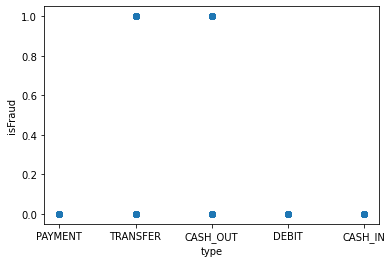

In [9]:
# Graficando las operaciones versus fraude detectado, se puede ver que, como de esperarse, 
# los fraudes son cometidos en la operacion de transferencia y operacion de extraccion
plt.scatter(x='type',y='isFraud',data=dataset_)
plt.xlabel('type')
plt.ylabel('isFraud')

<AxesSubplot:xlabel='type', ylabel='count'>

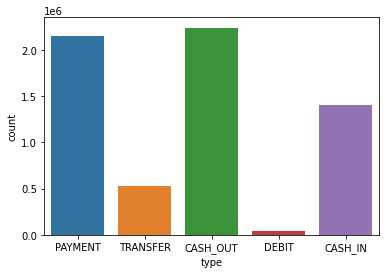

In [10]:
#Type está desbalanceado
sns.countplot(x='type',data=dataset_)

#### Vamos a verificar el balanceo de dataset y corregir

In [11]:
#Dataset desbalanceado en la variable objetivo
print(pd.value_counts(dataset_["isFraud"]))

0    6354407
1       8213
Name: isFraud, dtype: int64


In [12]:
#Veamos la cantidad de operaciones por tipo de operación, 
# podemos ver que el dataset se encuentra desbalanceado en cuanto a tipo de operación.
print(pd.value_counts(dataset_["type"]))

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


In [13]:
# Vamos a separar el dataset en operaciones fraudulentas y las que no lo son,
#  por el momento no tomamos en cuenta el balanceo de tipo de operacion. 
is_fraud=dataset_[dataset_["isFraud"]==1]
print("Fraudes detectados: {}".format(is_fraud.shape[0]))

Fraudes detectados: 8213


In [14]:
#subsampleamos la parte de dataset que no tiene fraude detectado a la misma cantidad de filas 
# que el subset con fraudes
not_fraud=dataset_[dataset_["isFraud"]!=1].sample(n=8213)
#concatenamos las dos partes y reseteamos el indice

In [15]:
new_df= pd.concat([is_fraud, not_fraud], axis = 0).reset_index().drop(columns={"index"})
print("1:Fraude \n 0: No es fraude \n",new_df.isFraud.value_counts())
print(new_df.type.value_counts())
#Si bien vemos que Debito no está bien representado, 
# al mismo tiempo no es una variable de interés, por lo que vamos a observar mas adelante

1:Fraude 
 0: No es fraude 
 1    8213
0    8213
Name: isFraud, dtype: int64
CASH_OUT    6974
TRANSFER    4788
PAYMENT     2757
CASH_IN     1865
DEBIT         42
Name: type, dtype: int64


In [16]:
# Veamos que el subset nuevo tiene caracteristicas similares al original, 
# sobre todo en las columnas newBalance y monto, en la columna isFraud se observarán
# cambios, debido al balanceo.
new_df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,16426.000000,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,1.642600e+04,16426.000000
mean,305.592049,8.232600e+05,1.258288e+06,5.418214e+05,8.479937e+05,1.275884e+06,0.500000
std,193.444698,1.851848e+06,3.278150e+06,2.544042e+06,3.360751e+06,3.745815e+06,0.500015
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,161.000000,3.736835e+04,1.055300e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,283.000000,1.733677e+05,1.205909e+05,0.000000e+00,0.000000e+00,1.239624e+05,0.500000
75%,409.000000,5.414867e+05,8.131333e+05,0.000000e+00,5.135582e+05,1.090338e+06,1.000000
max,743.000000,1.799231e+07,5.958504e+07,4.958504e+07,2.362305e+08,2.367265e+08,1.000000


In [17]:
# Verifiquemos que nuestro dataset no tiene Nans
for column in dataset_:
   count=new_df[column][new_df[column].isna()].sum()
   print(column,"total de NaN",count)

step total de NaN 0
type total de NaN 0
amount total de NaN 0.0
nameOrig total de NaN 0
oldbalanceOrg total de NaN 0.0
newbalanceOrig total de NaN 0.0
nameDest total de NaN 0
oldbalanceDest total de NaN 0.0
newbalanceDest total de NaN 0.0
isFraud total de NaN 0


#### Se grafica scatter plot, histogram y box and wisker de daaset reducido [new_df]

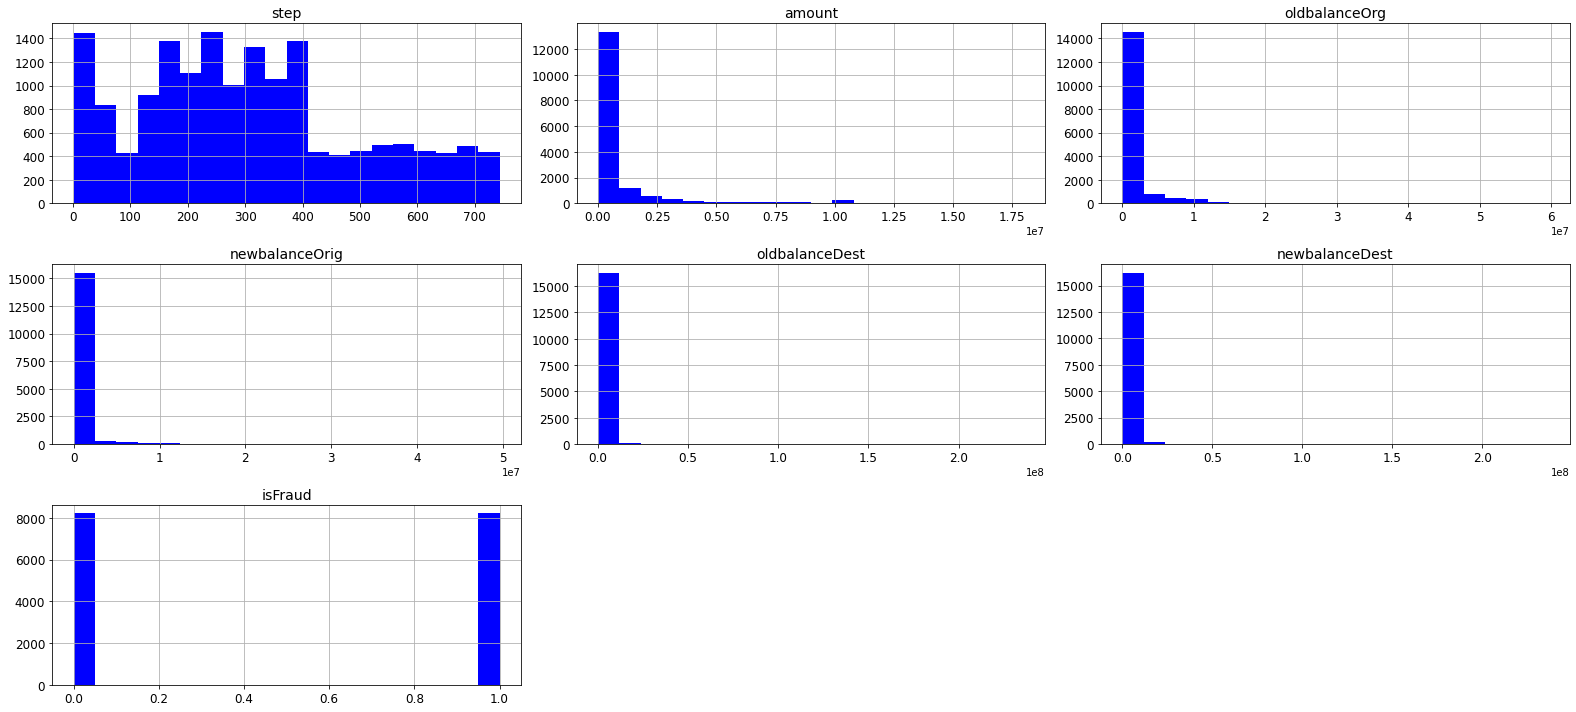

In [18]:
# Visualizamos la distribución de cada columna, todas las columnas referidas a los montos tienen outliers

def display_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10), color='blue', bins=20)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()
display_distributions(new_df)

#### Grafiquemos tipo de transacción antes y despues de balanceo, podemos ver que ha cambiado ligeramente la representabilidad original. Se podría trabajar mas fino, y clasificar para cada transacción por separado, arrancando desde el balanceo de datos objetivo inicial

<AxesSubplot:xlabel='type', ylabel='count'>

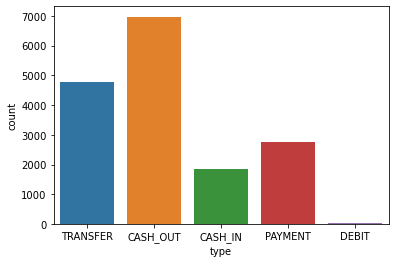

In [19]:
sns.countplot(x='type',data=new_df)

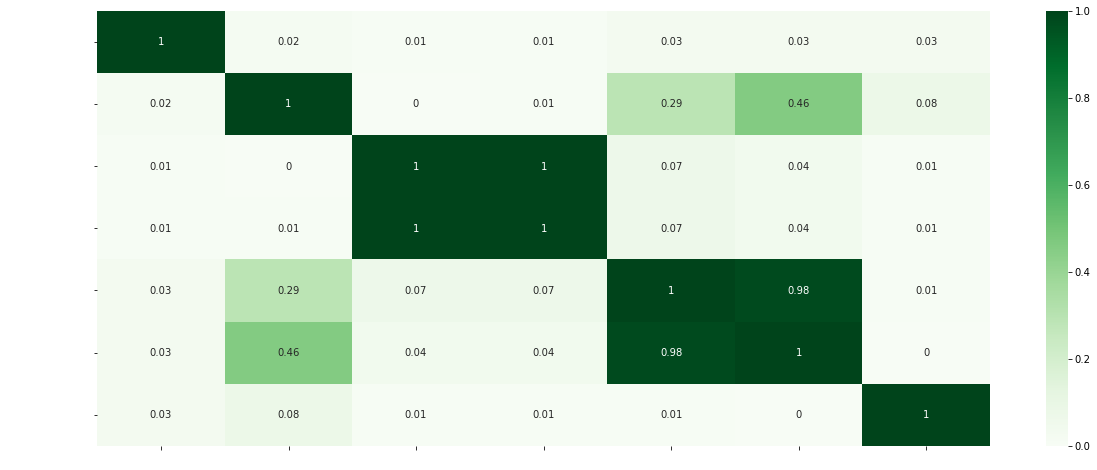

In [20]:
# Graficamos la matriz de correlación lineal. El resultado observado es el mismo para dataset 
# completo y para subset, se deja el ultimo.
# Se puede observar muy alta correlación entre la variables de input de NewBalance y OldBalance, 
# con lo cual podemos dropear, por ejemplo oldbalance sin riezgo de perder información.
correlation_matrix = dataset_[new_df.columns].corr().round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
[t.set_color('white') for t in axes.xaxis.get_ticklabels()]
[t.set_color('white') for t in axes.yaxis.get_ticklabels()]
sns.heatmap(data=np.abs(correlation_matrix), annot=True,ax=axes,cmap='Greens');

In [21]:
new_df_drop=new_df.drop(columns={"oldbalanceOrg","oldbalanceDest"})
new_df_drop.head(2)

,step,type,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,0.0,C553264065,0.0,1
1,1,CASH_OUT,181.0,C840083671,0.0,C38997010,0.0,1


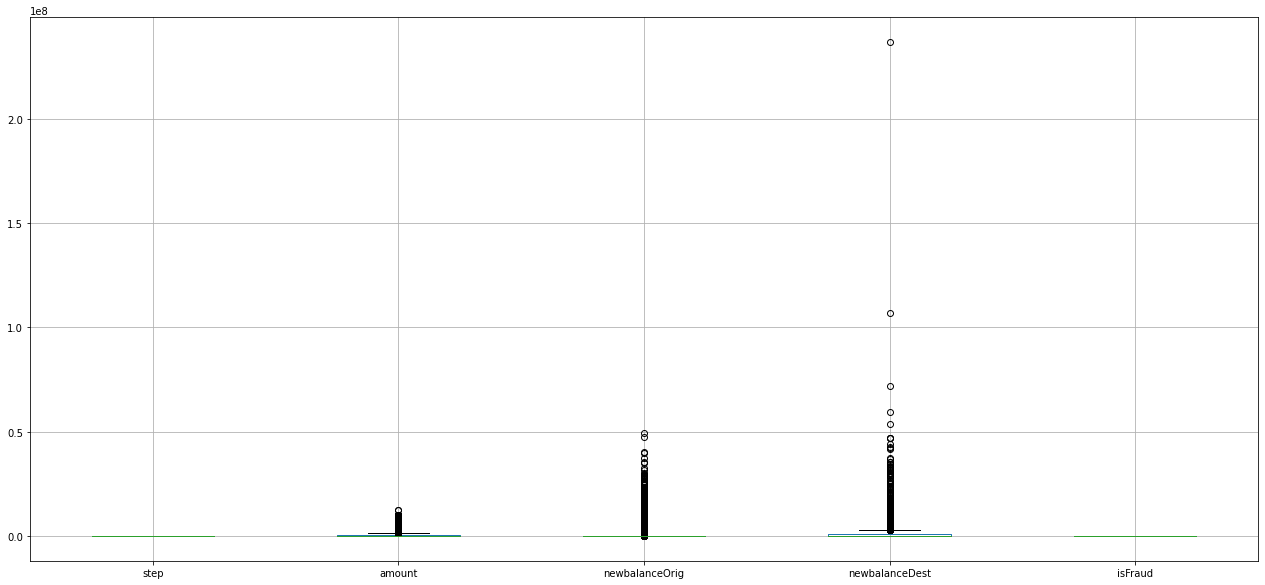

In [243]:
# Visualizamos los datos de cada columna, se observa una gran cantidad de ouliers. Para este estudio especifico
# no se tratarán los outliers, ya que pueden estar describiendo operaciones fraudulentas.
def display_boxplot(dataset):
    fig = dataset.boxplot(figsize=(22,10))
    #fig.set_ylim((0, 1))
    plt.show()
display_boxplot(pd.DataFrame(new_df_drop))

##### Labeling

In [56]:
# Codificamos la columna type
# 
type_new = pd.get_dummies(new_df_drop['type'],drop_first=True)
type_new

,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,1,0,0,0
4,0,0,0,1
...,...,...,...,...
16421,1,0,0,0
16422,0,0,0,0
16423,0,0,1,0
16424,0,0,1,0


In [57]:
# Concatenamos las columnas codificadas
payments = pd.concat([new_df_drop,type_new],axis=1)

In [58]:
payments.head(2)

,step,type,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,TRANSFER,181.0,C1305486145,0.0,C553264065,0.0,1,0,0,0,1
1,1,CASH_OUT,181.0,C840083671,0.0,C38997010,0.0,1,1,0,0,0


In [59]:
# Armamos nuestro vector X e y (vector objetivo). Me quedo con las operaciones que tienen 
# fraudes y no tomaré en cuenta id de usuario
X = payments[['step','TRANSFER',"CASH_OUT",'amount','newbalanceOrig','newbalanceDest']]
y = payments['isFraud']



In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [61]:
scaler = StandardScaler()
X_train_s=scaler.fit_transform(X_train)
X_test_s=scaler.fit_transform(X_test)

(6, 6)


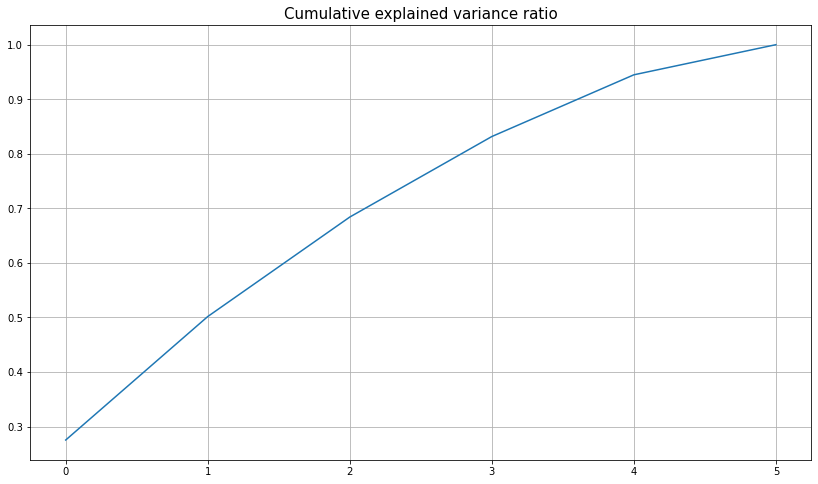

In [62]:
#Con cuatro variables de este dataset se explican 95%, 
# en este caso no es recomendable aplicar una reducción por PCA
from sklearn.decomposition import PCA
pca_ = PCA()
pca_.fit(X_train_s)
print(pca_.components_.shape)
fig,axes = plt.subplots(1,figsize=(14,8))
plt.plot(np.cumsum(pca_.explained_variance_ratio_)); plt.title("Cumulative explained variance ratio",fontsize=15);plt.grid(True);

#### Vamos a probar como performa el aprendizaje en los modelos para este dataset

> * El primer modelo mostrado aca, es el preferido. Se muestran todas las metricas

In [63]:
# Probamos SVC e imprimimos reporte de clasificación
clf_scv = SVC(decision_function_shape='ovo',random_state=0)
clf_scv.fit(X_train_s, y_train)
pred_svc = clf_scv.predict(X_test_s)
print(classification_report(y_test,pred_svc))
# Clase 0 precision: 0.86, recall: 0.95
# Clase 1 precision 0.94, recall: 0.84
#El modelo es relativamente performante

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2449
           1       0.94      0.84      0.89      2479

    accuracy                           0.89      4928
   macro avg       0.90      0.89      0.89      4928
weighted avg       0.90      0.89      0.89      4928



<AxesSubplot:>

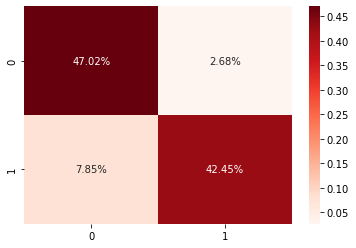

In [64]:
cm1 = confusion_matrix(y_test, pred_svc)
sns.heatmap(cm1/np.sum(cm1), annot = True, fmt=  '0.2%', cmap = 'Reds')

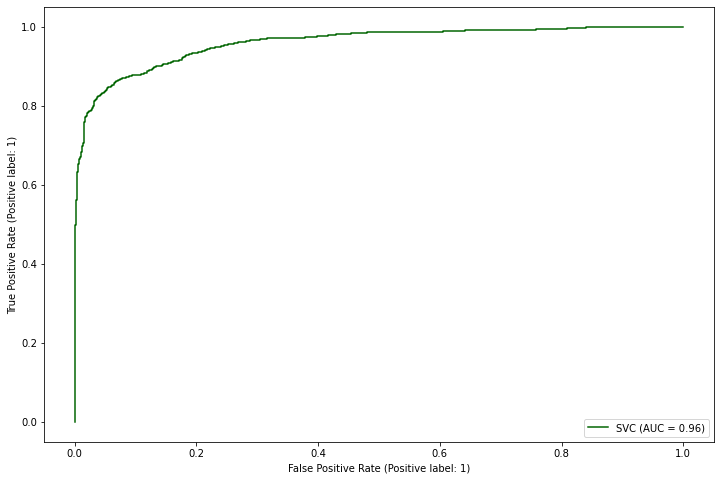

In [65]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_roc_curve(clf_scv, X_test_s, y_test, color='darkgreen', ax=ax)


In [78]:
# idem Random Forest, con parametros default y los puestos actualmente, 
# el modelo no performa correctamente
clf_rf = RandomForestClassifier(criterion= 'gini', max_depth= 2, n_estimators= 100)
clf_rf.fit(X_train_s, y_train)
pred_rf = clf_rf.predict(X_test_s)
print(classification_report(y_test,pred_rf))

              precision    recall  f1-score   support

           0       0.68      0.97      0.80      2449
           1       0.95      0.55      0.70      2479

    accuracy                           0.76      4928
   macro avg       0.82      0.76      0.75      4928
weighted avg       0.82      0.76      0.75      4928



In [67]:
# idem Random Forest, con parametros default y los puestos actualmente, 
# el modelo no performa correctamente, sobreajusta
clf_dt = DecisionTreeClassifier(max_depth=10,random_state=47)
clf_dt.fit(X_train_s, y_train)
pred_rf = clf_dt.predict(X_test_s)
print(classification_report(y_test,pred_rf))


              precision    recall  f1-score   support

           0       0.58      0.98      0.72      2449
           1       0.93      0.29      0.44      2479

    accuracy                           0.63      4928
   macro avg       0.75      0.63      0.58      4928
weighted avg       0.75      0.63      0.58      4928



In [68]:
# Regresión logistica con los parametros eligidos tiene un performance aceptable
clf_lr =LogisticRegression(max_iter=120,random_state=0, n_jobs=20, solver='liblinear')
clf_lr.fit(X_train_s, y_train)
pred_lr = clf_lr.predict(X_test_s)
print(classification_report(y_test,pred_lr))




              precision    recall  f1-score   support

           0       0.86      0.79      0.82      2449
           1       0.81      0.87      0.84      2479

    accuracy                           0.83      4928
   macro avg       0.83      0.83      0.83      4928
weighted avg       0.83      0.83      0.83      4928



c:\Users\54922\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


#### Veamos si podemos mejorar, implementamos busqueda de hiperparametros para los modelos de prueba, usando Gridsearch y hacemos crossvalidación para el modelo definido:

In [69]:
# Definimos una función de busqueda de hiperparametros, usando gridsearch
def grid(model,params,X_train, y_train,X_test,y_test):
    scores = ["precision"]   ##"recall"

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(model, params, scoring="%s_macro" % score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_["mean_test_score"]
        stds = clf.cv_results_["std_test_score"]
        for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

In [70]:
params_dtc = [{"splitter":["best", "random"], "criterion": ["gini","entropy"], "max_depth": range(2,17,5),"min_samples_leaf":[1,3]}]
dtc=DecisionTreeClassifier()
grid(dtc,params_dtc,X_train_s, y_train,X_test_s,y_test)
#podemos ver que tiende a tomar mayor profundidad y sobreajustar. Conviene tomar profundidad 
# fija y ajustar demas parametros en gridsearch

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3, 'splitter': 'best'}

Grid scores on development set:

0.809 (+/-0.048) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'splitter': 'best'}
0.849 (+/-0.007) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'splitter': 'random'}
0.809 (+/-0.048) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'splitter': 'best'}
0.849 (+/-0.007) for {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 3, 'splitter': 'random'}
0.917 (+/-0.014) for {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'splitter': 'best'}
0.881 (+/-0.028) for {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'splitter': 'random'}
0.916 (+/-0.014) for {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3, 'splitter': 'best'}
0.870 (+/-0.033) for {'criterion': 'gini', 'max_depth': 7, 'min_samples_l

In [71]:
params_rfc = [{"n_estimators": range(50,200,50), "criterion": ["gini","entropy"], "max_depth": range(2,17,5)}]
rfc=RandomForestClassifier()
grid(rfc,params_rfc,X_train_s, y_train,X_test_s,y_test)
#pasa lo mismo que en caso de decision tree

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 12, 'n_estimators': 100}

Grid scores on development set:

0.869 (+/-0.012) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 50}
0.866 (+/-0.011) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 100}
0.870 (+/-0.023) for {'criterion': 'gini', 'max_depth': 2, 'n_estimators': 150}
0.927 (+/-0.008) for {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 50}
0.926 (+/-0.006) for {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
0.928 (+/-0.009) for {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 150}
0.929 (+/-0.010) for {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 50}
0.930 (+/-0.009) for {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 100}
0.930 (+/-0.008) for {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 150}
0.866 (+/-0.013) for {'criterion': 'entropy', 'max_depth': 2, 'n_estimators': 50}
0.870 (+/-0.0

In [72]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
params_svc = [{"kernel": ["rbf","sigmoid"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]}]
svc=SVC()
grid(svc,params_svc,X_train_s, y_train,X_test_s,y_test)
#probamos estos parametros para modelo de scv, para ver si mejoran el modelo anterior

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.845 (+/-0.010) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.844 (+/-0.005) for {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.823 (+/-0.021) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.796 (+/-0.017) for {'C': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.839 (+/-0.012) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.834 (+/-0.015) for {'C': 10, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.846 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.845 (+/-0.005) for {'C': 10, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.860 (+/-0.015) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.845 (+/-0.016) for {'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.836 (+/-0.014) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.834 (+/-0.015) for {'C': 100, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.883 (+/-0.011) for {'C': 1000, 'g

In [73]:
params_lrc = [{"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"], "C": [1, 10, 100, 1000]}]
lrc=LogisticRegression()
grid(lrc,params_lrc,X_train_s, y_train,X_test_s,y_test)



# Tuning hyper-parameters for precision



c:\Users\54922\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\54922\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\54922\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\54922\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\54922\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

Best parameters set found on development set:

{'C': 10, 'solver': 'newton-cg'}

Grid scores on development set:

0.840 (+/-0.016) for {'C': 1, 'solver': 'newton-cg'}
0.840 (+/-0.016) for {'C': 1, 'solver': 'lbfgs'}
0.840 (+/-0.016) for {'C': 1, 'solver': 'liblinear'}
0.840 (+/-0.016) for {'C': 1, 'solver': 'sag'}
0.840 (+/-0.016) for {'C': 1, 'solver': 'saga'}
0.841 (+/-0.016) for {'C': 10, 'solver': 'newton-cg'}
0.841 (+/-0.016) for {'C': 10, 'solver': 'lbfgs'}
0.841 (+/-0.016) for {'C': 10, 'solver': 'liblinear'}
0.840 (+/-0.015) for {'C': 10, 'solver': 'sag'}
0.840 (+/-0.015) for {'C': 10, 'solver': 'saga'}
0.841 (+/-0.016) for {'C': 100, 'solver': 'newton-cg'}
0.841 (+/-0.016) for {'C': 100, 'solver': 'lbfgs'}
0.841 (+/-0.016) for {'C': 100, 'solver': 'liblinear'}
0.840 (+/-0.015) for {'C': 100, 'solver': 'sag'}
0.840 (+/-0.015) for {'C': 100, 'solver': 'saga'}
0.841 (+/-0.016) for {'C': 1000, 'solver': 'newton-cg'}
0.841 (+/-0.016) for {'C': 1000, 'solver': 'lbfgs'}
0.841 (+/-0.0

#### Hasta el momento vimos que el mejor performance tiene SCV, esto no quiere decir que Random Forest no pueda ser implementado, solo se tienen que buscar parametros que eviten sobreajuste,probamos los nuevos parametros para ver SCV:

In [76]:
clf_scv_2 = SVC(random_state=0,C= 1000, gamma= 0.001, kernel= "rbf")
clf_scv_2.fit(X_train_s, y_train)
pred_svc_2 = clf_scv_2.predict(X_test_s)
print(classification_report(y_test,pred_svc_2))
#Podemos ver que el modelo anterior de SCV, sigue siendo bien performante

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2449
           1       0.93      0.83      0.88      2479

    accuracy                           0.88      4928
   macro avg       0.89      0.88      0.88      4928
weighted avg       0.89      0.88      0.88      4928



#### Prueba de Cross Validación 

In [77]:
# no se observa mejora de metrica
model = SVC(decision_function_shape='ovo',random_state=0)
print("modelo:",model)
for k in range(2,7):
    cv = KFold(n_splits=k, random_state=1, shuffle=True)
    # evaluate model
    scores = cross_val_score(model, X_train_s, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print("n_splits: ",k,'\n Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

modelo: SVC(decision_function_shape='ovo', random_state=0)
n_splits:  2 
 Accuracy: 0.894 (0.005)
n_splits:  3 
 Accuracy: 0.895 (0.008)
n_splits:  4 
 Accuracy: 0.895 (0.006)
n_splits:  5 
 Accuracy: 0.895 (0.009)
n_splits:  6 
 Accuracy: 0.896 (0.011)
